# Training EfficientNet B3 for Skin Cancer Detection

This notebook contains the steps for training and fine-tuning the EfficientNet B3 model on the preprocessed skin lesion images.

## 1. Import Libraries

First, we need to import the necessary libraries.

In [1]:
import os
import numpy as np
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0 as EFNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import json

### Checking whether tensorflow is detecting GPU or not

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

tf.config.run_functions_eagerly(True)

1 Physical GPUs, 1 Logical GPU


## 2. Define Directories

Next, we define the directories for the processed data and the saved models.

In [29]:
BASE_DIR = r"G:\OneDrive\ML-MinorProject\ISIC Dataset"
PROCESSED_TRAIN_DIR = os.path.join(BASE_DIR, "processed_train")
PROCESSED_VAL_DIR = os.path.join(BASE_DIR, "processed_val")
PROCESSED_TEST_DIR = os.path.join(BASE_DIR, "processed_test")
MODEL_DIR = r"G:\OneDrive\ML-MinorProject\models"
EFFICIENTNET_MODEL_PATH = os.path.join(MODEL_DIR, "efficientnet", "efficientnet_final_model.h5")
EFFICIENT_TRAINING_HISTORY_PATH=os.path.join(MODEL_DIR, "efficientnet", "efficientnet_training_history.json")

## 3. Image Processing Configurations

We define the image processing configurations and create data generators.

In [17]:
IMG_SIZE = (224, 224)  # EfficientNetB0 input size
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    PROCESSED_TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    PROCESSED_VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    PROCESSED_TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 10730 images belonging to 2 classes.
Found 2944 images belonging to 2 classes.
Found 1994 images belonging to 2 classes.


## 4. Visualize Data Augmentation

We visualize some augmented images to ensure that the augmentations are applied correctly.

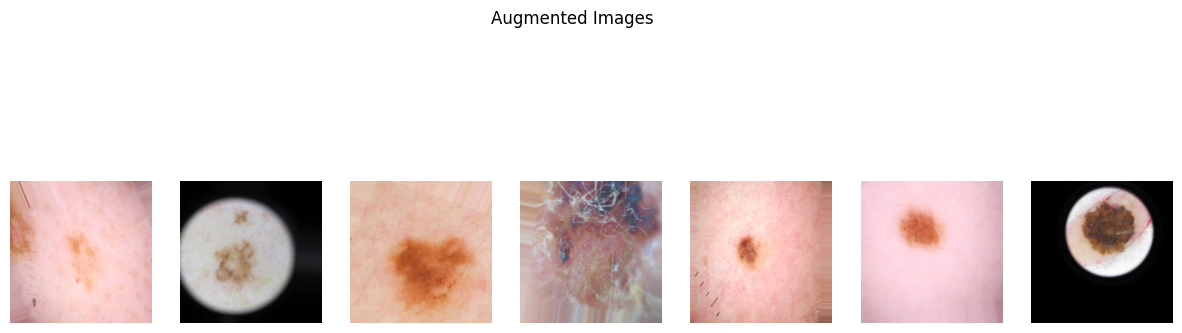

In [7]:
import matplotlib.pyplot as plt
def visualize_augmentation(generator):
    batch = next(generator)
    images = batch[0]
    
    plt.figure(figsize=(15, 5))
    for i in range(7):
        plt.subplot(1, 7, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle("Augmented Images")
    plt.show()

visualize_augmentation(train_generator)

## 5. Enable Mixed Precision

We enable mixed precision to improve training performance.

In [8]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050 Ti, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## 6. Define and Compile Model

We define and compile the EfficientNet B3 model architecture.

In [19]:
base_model = EFNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


## 7. Define Callbacks

We define callbacks to improve the training process.

In [20]:
checkpoint = ModelCheckpoint(
    EFFICIENTNET_MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    mode="min",
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

## 8. Train the Model

We train the model using the data generators.

In [21]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/20
671/671 [==============================] - 696s 1s/step - loss: 0.4014 - accuracy: 0.8102 - val_loss: 0.5801 - val_accuracy: 0.7272 - lr: 1.0000e-04
Epoch 2/20
671/671 [==============================] - 682s 1s/step - loss: 0.3450 - accuracy: 0.8460 - val_loss: 0.7010 - val_accuracy: 0.7089 - lr: 1.0000e-04
Epoch 3/20
671/671 [==============================] - 669s 996ms/step - loss: 0.3154 - accuracy: 0.8592 - val_loss: 0.5972 - val_accuracy: 0.7334 - lr: 1.0000e-04
Epoch 4/20
671/671 [==============================] - 665s 990ms/step - loss: 0.3056 - accuracy: 0.8651 - val_loss: 0.6246 - val_accuracy: 0.6889 - lr: 1.0000e-04
Epoch 5/20
671/671 [==============================] - 678s 1s/step - loss: 0.2895 - accuracy: 0.8706 - val_loss: 0.8160 - val_accuracy: 0.7632 - lr: 1.0000e-04
Epoch 6/20
671/671 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.8797
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
671/671 [============

## 9. Fine-Tune the Model

We unfreeze the base model and fine-tune the entire model.

In [22]:
# Unfreeze the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10
671/671 [==============================] - 718s 1s/step - loss: 0.3388 - accuracy: 0.8428 - val_loss: 0.5863 - val_accuracy: 0.7717 - lr: 1.0000e-05
Epoch 2/10
671/671 [==============================] - 697s 1s/step - loss: 0.3233 - accuracy: 0.8541 - val_loss: 0.6423 - val_accuracy: 0.7632 - lr: 1.0000e-05
Epoch 3/10
671/671 [==============================] - 834s 1s/step - loss: 0.3301 - accuracy: 0.8485 - val_loss: 0.5940 - val_accuracy: 0.7768 - lr: 1.0000e-05
Epoch 4/10
671/671 [==============================] - 795s 1s/step - loss: 0.3209 - accuracy: 0.8532 - val_loss: 0.6036 - val_accuracy: 0.7772 - lr: 1.0000e-05
Epoch 5/10
671/671 [==============================] - 765s 1s/step - loss: 0.3170 - accuracy: 0.8559 - val_loss: 0.6582 - val_accuracy: 0.7656 - lr: 1.0000e-05
Epoch 6/10
671/671 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.8596
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
671/671 [==================

## 10. Save the Final Model

We save the final model after training and fine-tuning.

In [25]:

model.save(EFFICIENTNET_MODEL_PATH)
print(f"Final model saved to {EFFICIENTNET_MODEL_PATH}")

Final model saved to G:\OneDrive\ML-MinorProject\models\efficientnet\efficientnet_best_model.h5


## 11. Save Training history
We save the training history of a model in a json file.

In [32]:
import pandas as pd
hist_df=pd.DataFrame(history.history)
with open(EFFICIENT_TRAINING_HISTORY_PATH, 'w') as f:
    hist_df.to_json(EFFICIENT_TRAINING_HISTORY_PATH)